In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import pickle

In [15]:
data = pd.read_csv('data/cleaned_norm_data.csv')

X = data.drop(columns=['id', 'churn'])
y = data['churn']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

rf = RandomForestClassifier(random_state=42)

In [17]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             scoring='f1')

In [18]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_scaled)
y_pred_prob = best_model.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Точність: {accuracy:.2f}")
print(f"Точність (Precision): {precision:.2f}")
print(f"Повнота (Recall): {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Точність: 0.74
Точність (Precision): 0.77
Повнота (Recall): 0.75
F1 Score: 0.76


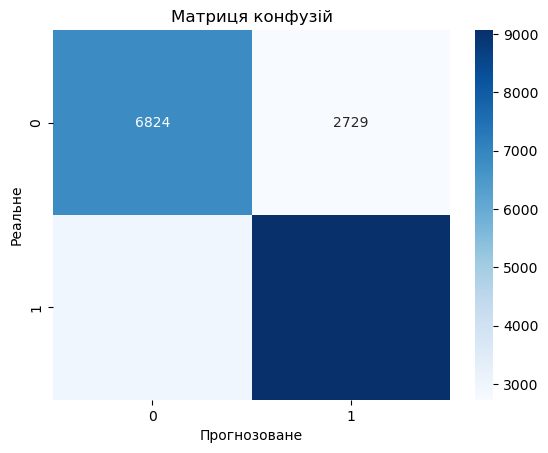

In [19]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Матриця конфузій')
plt.xlabel('Прогнозоване')
plt.ylabel('Реальне')
plt.show()

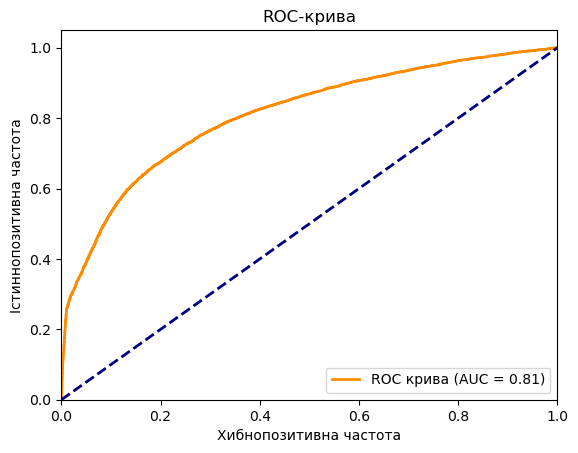

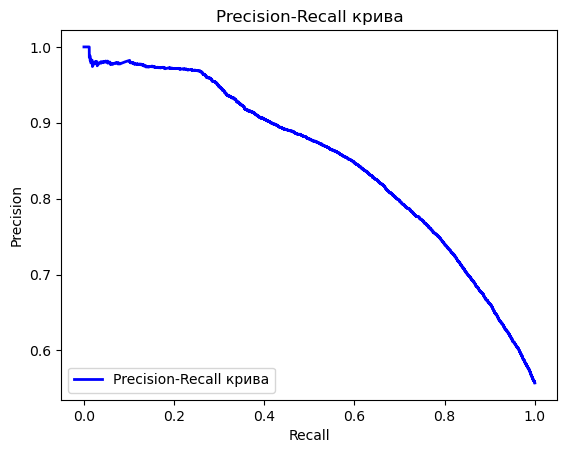

              precision    recall  f1-score   support

           0       0.70      0.71      0.71      9553
           1       0.77      0.75      0.76     12015

    accuracy                           0.74     21568
   macro avg       0.73      0.73      0.73     21568
weighted avg       0.74      0.74      0.74     21568



In [20]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC крива (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Хибнопозитивна частота')
plt.ylabel('Істиннопозитивна частота')
plt.title('ROC-крива')
plt.legend(loc="lower right")
plt.show()

precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(recall_curve, precision_curve, lw=2, color='blue', label='Precision-Recall крива')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall крива')
plt.legend(loc="lower left")
plt.show()

print(classification_report(y_test, y_pred))

In [21]:
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)